# Shot Visualizations

In [1]:
import plotly
# import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import mysql.connector
import config
import warnings
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from plotly.subplots import make_subplots

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set_style('darkgrid')

warnings.simplefilter('ignore')

In [2]:
dbname = 'nba'
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname
)
cursor = cnx.cursor(buffered = True)

## Traditional positions

In [3]:
pre_clust_18 = pd.read_csv('jc_custom_shot_groups_for_custering_2018.csv').drop('Unnamed: 0', axis=1)

### Distribution of average shot distance for each player

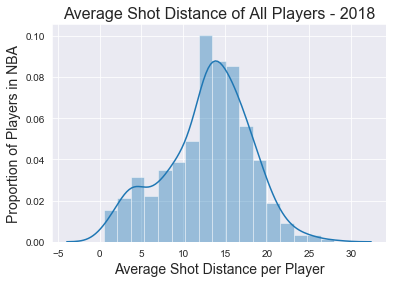

In [69]:
sns.distplot(pre_clust_18['avg_shot_distance_all'])
plt.title('Average Shot Distance of All Players - 2018', fontdict={'size': 16})
plt.xlabel('Average Shot Distance per Player', fontdict={'size':14})
plt.ylabel('Proportion of Players in NBA',  fontdict={'size':14})
plt.savefig('avg_shot_distance.jpeg')

### Distribution of shot distance by traditional positions

In [4]:
stmt = "SELECT * from nba.box_score"
cursor.execute(stmt)
scores = cursor.fetchall()

field_names = [i[0] for i in cursor.description]
box_scores = pd.DataFrame(scores).dropna()
box_scores.columns = field_names

#### Merge positions from box_score table

In [71]:
box_scores_18 = box_scores[box_scores['GAME_ID'].str.contains('00218')]
unique_players_18 = box_scores.drop_duplicates(subset='PLAYER_NAME')
start_positions_18 = pre_clust_18.merge(unique_players_18[['PLAYER_ID', 'START_POSITION']],
                                        left_on='player_id', right_on='PLAYER_ID', how='left')
drop_index = start_positions_18[start_positions_18['START_POSITION']==''].index
positions_18_only = start_positions_18.drop(drop_index)


In [72]:
positions_18_only.groupby('START_POSITION').agg('mean')['avg_shot_distance_all']

START_POSITION
C     8.303303
F    13.080385
G    14.504794
Name: avg_shot_distance_all, dtype: float64

#### Shot distances by traditional positions

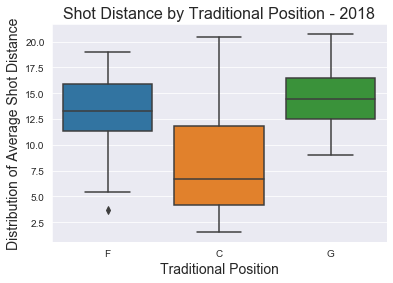

In [73]:
sns.boxplot(x=positions_18_only['START_POSITION'], y=positions_18_only['avg_shot_distance_all'])
plt.title('Shot Distance by Traditional Position - 2018', fontdict={'size':16})
plt.xlabel('Traditional Position', fontdict={'size': 14})
plt.ylabel('Distribution of Average Shot Distance', fontdict={'size': 14})
plt.savefig('distribution_shot_distance_traditional.jpeg')

## Get shots from database

In [74]:
stmt = "SELECT * from nba.shot_chart"
cursor.execute(stmt)
scores = cursor.fetchall()

field_names = [i[0] for i in cursor.description]
shots = pd.DataFrame(scores)
shots.columns = field_names

In [75]:
shots.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

In [76]:
type(shots['GAME_ID'].values[0])

str

In [77]:
shots[shots['PLAYER_NAME'] == 'Ben Simmons']

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
403975,Shot Chart Detail,0021700006,33,1627732,Ben Simmons,1610612755,Philadelphia 76ers,1,9,44,...,Center(C),Less Than 8 ft.,3,-18,26,1,0,20171018,WAS,PHI
403976,Shot Chart Detail,0021700006,47,1627732,Ben Simmons,1610612755,Philadelphia 76ers,1,8,28,...,Center(C),Less Than 8 ft.,1,12,11,1,1,20171018,WAS,PHI
403977,Shot Chart Detail,0021700006,77,1627732,Ben Simmons,1610612755,Philadelphia 76ers,1,5,54,...,Right Side(R),8-16 ft.,9,73,55,1,1,20171018,WAS,PHI
403978,Shot Chart Detail,0021700006,182,1627732,Ben Simmons,1610612755,Philadelphia 76ers,2,11,43,...,Center(C),Less Than 8 ft.,0,0,-6,1,1,20171018,WAS,PHI
403979,Shot Chart Detail,0021700006,187,1627732,Ben Simmons,1610612755,Philadelphia 76ers,2,10,42,...,Center(C),Less Than 8 ft.,0,8,1,1,1,20171018,WAS,PHI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537668,Shot Chart Detail,0021900630,217,1627732,Ben Simmons,1610612755,Philadelphia 76ers,2,7,30,...,Right Side(R),8-16 ft.,8,54,68,1,0,20200118,NYK,PHI
537669,Shot Chart Detail,0021900630,300,1627732,Ben Simmons,1610612755,Philadelphia 76ers,2,1,36,...,Center(C),Less Than 8 ft.,1,-11,10,1,0,20200118,NYK,PHI
537670,Shot Chart Detail,0021900630,479,1627732,Ben Simmons,1610612755,Philadelphia 76ers,3,0,2,...,Center(C),Less Than 8 ft.,4,-29,29,1,0,20200118,NYK,PHI
537671,Shot Chart Detail,0021900630,482,1627732,Ben Simmons,1610612755,Philadelphia 76ers,3,0,0,...,Left Side(L),16-24 ft.,19,-191,4,1,0,20200118,NYK,PHI


In [78]:
string = '2017'
string = string[0] + string[2:]
string

'217'

## Draw court

### Function to draw arcs in plotly

In [79]:
def ellipse_arc(x_center=0, y_center=0, a=1, b =1, start_angle=0, end_angle=2*np.pi, N=100, closed= False):
    t = np.linspace(start_angle, end_angle, N)
    x = x_center + a*np.cos(t)
    y = y_center + b*np.sin(t)
    path = f'M {x[0]}, {y[0]}'
    for k in range(1, len(t)):
        path += f'L{x[k]}, {y[k]}'
    if closed:
        path += ' Z'
    return path    


### Create list of court shapes

In [80]:
 court_shapes =[
     ## basket
     go.layout.Shape(
            type="circle",
            xref="x",
            yref="y",
            x0=-7.5,
            y0=-7.5,
            x1=7.5,
            y1=7.5,
            line_color="Black",
        ),
            
     ## backboard
     go.layout.Shape(
            type="rect",
            x0=-30,
            y0=-7.5,
            x1=30,
            y1=-7.5,
            line_color="Black"),
            
     ## outer paint       
     go.layout.Shape(
            type="rect",
            x0=-80,
            y0=-47.5,
            x1=80,
            y1=142.5,
            line_color="Black"),
     
     ## inner paint        
     go.layout.Shape(
            type="rect",
            x0=-60,
            y0=-47.5,
            x1=60,
            y1=142.5,
            line_color="Black"),
               
     ## arc above free throw line
     dict(type="path",
            path= ellipse_arc(y_center= 140, a=60, b=60, start_angle=0, end_angle=3*np.pi/3, N=100),
            line_color="Black"),
     ## arc below free throw line          
     dict(type="path",
            path= ellipse_arc(y_center= 140, a=60, b=60, start_angle=0, end_angle=-3*np.pi/3, N=100),
            line_color="Black"),
     
     ## left corner three point line          
     go.layout.Shape(
            type="rect",
            x0=-220,
            y0=-47.5,
            x1=-220,
            y1=92.5,
            line_color="Black"),  
     
     ## right corner three point line       
     go.layout.Shape(
            type="rect",
            x0=220,
            y0=-47.5,
            x1=220,
            y1=92.5,
            line_color="Black"),
       
     
     ## three point arc    
     dict(type="path",
            path= ellipse_arc(y_center= 92.5, a=220, b=146.5, start_angle=0, end_angle=3*np.pi/3, N=100),
            line_color="Black"),
     ## out of bounds line and half court           
     go.layout.Shape(
            type="rect",
            x0=-250,
            y0=-47.5,
            x1=250,
            y1=422.5,
            line_color="Black"),

     ## restricted area        
     dict(type="path",
            path= ellipse_arc(a=40, b=40, start_angle=0, end_angle=3*np.pi/3, N=100),
            line_color="Black"),
     
     ## center court circle outer
     dict(type="path",
            path= ellipse_arc(y_center= 422.5, a=60, b=60, start_angle=0, end_angle=-3*np.pi/3, N=100),
            line_color="Black"),
     
     ## center court circle inner   
     dict(type="path",
            path= ellipse_arc(y_center= 422.5, a=20, b=20, start_angle=0, end_angle=-3*np.pi/3, N=100),
            line_color="Black"),   
               ]  



## Shot chart functions

### Function to plot shot chart for a player

In [81]:
def shot_chart(name, year=''):    
    if year:
        year_clean = '00' + year[0] + year[2:]
        player = shots[(shots.PLAYER_NAME == name) & (shots.GAME_ID.str.contains(year_clean))]
    else:
        player= shots[shots.PLAYER_NAME == name]

    missed_shot_trace = go.Scattergl(
            x = player[player.SHOT_MADE_FLAG == 0]['LOC_X'],
            y = player[player.SHOT_MADE_FLAG == 0]['LOC_Y'],
            mode = 'markers',
            name = 'Miss',
            marker= dict(color='blue', symbol='x', size=8, line={'width':1}, opacity=0.7),
            text = [str(sd) for sd in player[player.SHOT_MADE_FLAG == 0]['ACTION_TYPE']],
            hoverinfo = 'text'
        )
    made_shot_trace = go.Scattergl(
        x = player[player.SHOT_MADE_FLAG == 1]['LOC_X'],
        y = player[player.SHOT_MADE_FLAG == 1]['LOC_Y'],
        mode = 'markers',
        name='Make',
        marker= dict(color='red', symbol='circle', size=8, line={'width':1}, opacity=0.7),
        text = [str(sd) for sd in player[player.SHOT_MADE_FLAG == 1]['ACTION_TYPE']],
        hoverinfo = 'text'
    )

    
   
    data = [missed_shot_trace, made_shot_trace]
    layout = go.Layout(
        title= name + ' Shot Chart ' + year,
        showlegend =True,
        xaxis={'showgrid':False, 'range':[-250,250]},
        yaxis={'showgrid':False, 'range':[422.5,-47.5]},
        height = 600,
        width = 650,
        shapes=court_shapes)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

### Function to generate plotly trace for a shot chart

In [82]:
def shot_chart_trace(name, year=''):    
    if year:
        year_clean = '00' + year[0] + year[2:]
        player = shots[(shots.PLAYER_NAME == name) & (shots.GAME_ID.str.contains(year_clean))]
    else:
        player= shots[shots.PLAYER_NAME == name]

    missed_shot_trace = go.Scattergl(
            x = player[player.SHOT_MADE_FLAG == 0]['LOC_X'],
            y = player[player.SHOT_MADE_FLAG == 0]['LOC_Y'],
            mode = 'markers',
            name = 'Miss',
            marker= dict(color='blue', symbol='x', size=8, line={'width':1}, opacity=0.7),
            text = [str(sd) for sd in player[player.SHOT_MADE_FLAG == 0]['ACTION_TYPE']],
            hoverinfo = 'text'
        )
    made_shot_trace = go.Scattergl(
        x = player[player.SHOT_MADE_FLAG == 1]['LOC_X'],
        y = player[player.SHOT_MADE_FLAG == 1]['LOC_Y'],
        mode = 'markers',
        name='Make',
        marker= dict(color='red', symbol='circle', size=8, line={'width':1}, opacity=0.7),
        text = [str(sd) for sd in player[player.SHOT_MADE_FLAG == 1]['ACTION_TYPE']],
        hoverinfo = 'text'
    )

    
   
    data = [missed_shot_trace, made_shot_trace]


    return data

In [83]:
shot_chart('Rajon Rondo', '2018')

### Function to find players who shoot similar shots

In [84]:
def similar_shooters(name, year=''):
        if year:
            year_clean = '00' + year[0] + year[2:]
            df = shots[shots['GAME_ID'].str.contains(year_clean)]
        else:
            df
        
        ### Get dummies for action types
        dummy = pd.get_dummies(df, columns=['ACTION_TYPE', 'SHOT_TYPE'], prefix=['',''], prefix_sep=['',''])
        
        attempts = pd.DataFrame(dummy.groupby('PLAYER_NAME')['SHOT_ATTEMPTED_FLAG'].agg(sum))
        ### get list of players to drop who take less that 250 shots
        to_drop = attempts[attempts['SHOT_ATTEMPTED_FLAG'] < 250]
        
        
        shot_breakdown = dummy.drop(labels=['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA',
       'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y',
       'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM', '2PT Field Goal', '3PT Field Goal'], axis=1)
        
        ## calculate breakdown of field goal attempts by shot type
        grouped = shot_breakdown.groupby('PLAYER_NAME').agg('mean')
        grouped.drop(to_drop.index, inplace=True)
        
        ## find players most frequent shot type
        col = grouped.idxmax(axis=1)[name]
        
        sorted_ = grouped.sort_values(col)
        
        ## get players who shoot most frequent shot similar amount of times
        head = pd.DataFrame(sorted_.loc[:name, col].tail())
        tail = pd.DataFrame(sorted_.loc[name:, col].head())
        
        final = pd.concat([head,tail]).reset_index().drop_duplicates()
    
        data = go.Bar(x=final['PLAYER_NAME'].values, 
                  y=final[col].values)
        layout = go.Layout(
                        title =  'Players who shoot a similar percentage of {} top shot '.format(name) + year)
    
        fig = go.Figure(data=data, layout = layout)
        fig.show()

### Function to generate plotly trace for similar shooters

In [85]:
def similar_shooters_trace(name, year=''):
        if year:
            year_clean = '00' + year[0] + year[2:]
            df = shots[shots['GAME_ID'].str.contains(year_clean)]
        else:
            df
        
        
        dummy = pd.get_dummies(df, columns=['ACTION_TYPE', 'SHOT_TYPE'], prefix=['',''], prefix_sep=['',''])
        
        attempts = pd.DataFrame(dummy.groupby('PLAYER_NAME')['SHOT_ATTEMPTED_FLAG'].agg(sum))
        to_drop = attempts[attempts['SHOT_ATTEMPTED_FLAG'] < 250]
        
        
        shot_breakdown = dummy.drop(labels=['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA',
       'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y',
       'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM', '2PT Field Goal', '3PT Field Goal'], axis=1)
        
        grouped = shot_breakdown.groupby('PLAYER_NAME').agg('mean')
        grouped.drop(to_drop.index, inplace=True)
        
        col = grouped.idxmax(axis=1)[name]
        
        sorted_ = grouped.sort_values(col)
        
        head = pd.DataFrame(sorted_.loc[:name, col].tail())
        tail = pd.DataFrame(sorted_.loc[name:, col].head())
        
        final = pd.concat([head,tail]).reset_index().drop_duplicates()
    
        data = go.Bar(x=final['PLAYER_NAME'].values, 
                  y=final[col].values)
        return data

In [86]:
similar_shooters('Ben Simmons', '2017')

In [87]:
similar_shooters('James Harden', '2018')

### Function to plot shot breakdown for a player

In [88]:
def shot_breakdown(name, year = ''):    
    
    if year:
        year_clean = '00' + year[0] + year[2:]
        player = shots[(shots.PLAYER_NAME == name) & (shots.GAME_ID.str.contains(year_clean))]
    else:
        player= shots[shots.PLAYER_NAME == name]
        
    player_dummy = pd.get_dummies(player, columns=['ACTION_TYPE', 'SHOT_TYPE'], prefix=['',''], prefix_sep=['',''])
    
    shot_breakdown = player_dummy.drop(labels=['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA',
       'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y',
       'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM', '2PT Field Goal', '3PT Field Goal'], axis=1).mean()
    
    top_10_types = shot_breakdown.sort_values(ascending=False)[:10]
  
    
    data = go.Bar(x=top_10_types.index, 
                  y=top_10_types.values)
    layout = go.Layout(
                        title = name + ' Percentage of Shots Taken ' + year,
                        xaxis_title = 'Shot Type',
                        yaxis_title = 'Percentage of Shots Attempted')
    
    fig = go.Figure(data=data, layout = layout)
    fig.show()
    

### Function to generate plotly trace for shot breakdown

In [89]:
def shot_breakdown_trace(name, year = ''):    
    
    if year:
        year_clean = '00' + year[0] + year[2:]
        player = shots[(shots.PLAYER_NAME == name) & (shots.GAME_ID.str.contains(year_clean))]
    else:
        player= shots[shots.PLAYER_NAME == name]
        
    player_dummy = pd.get_dummies(player, columns=['ACTION_TYPE', 'SHOT_TYPE'], prefix=['',''], prefix_sep=['',''])
    
    shot_breakdown = player_dummy.drop(labels=['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA',
       'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y',
       'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM', '2PT Field Goal', '3PT Field Goal'], axis=1).mean()
    
    top_10_types = shot_breakdown.sort_values(ascending=False)[:10]
    
    data = go.Bar(x=top_10_types.index, 
                  y=top_10_types.values)

    return data

In [90]:
shot_breakdown('Ben Simmons', '2017')

### Function to plot shot chart for a cluster of players

In [91]:
def cluster_shot_chart(df, cluster, year):    
    player = df[df['cluster']==cluster]

    missed_shot_trace = go.Scattergl(
            x = player[player.SHOT_MADE_FLAG == 0]['LOC_X'],
            y = player[player.SHOT_MADE_FLAG == 0]['LOC_Y'],
            mode = 'markers',
            name = 'Miss',
            marker= dict(color='blue', symbol='x', size=8, line={'width':1}, opacity=0.7),
            text = [str(sd) for sd in player[player.SHOT_MADE_FLAG == 0]['ACTION_TYPE']],
            hoverinfo = 'text'
        )
    made_shot_trace = go.Scattergl(
        x = player[player.SHOT_MADE_FLAG == 1]['LOC_X'],
        y = player[player.SHOT_MADE_FLAG == 1]['LOC_Y'],
        mode = 'markers',
        name='Make',
        marker= dict(color='red', symbol='circle', size=8, line={'width':1}, opacity=0.7),
        text = [str(sd) for sd in player[player.SHOT_MADE_FLAG == 1]['ACTION_TYPE']],
        hoverinfo = 'text'
    )

    
   
    data = [missed_shot_trace, made_shot_trace]
    layout = go.Layout(
        title= 'Cluster {} '.format(str(cluster)) + ' Shot Chart ' + year,
        showlegend =True,
        xaxis={'showgrid':False, 'range':[-250,250]},
        yaxis={'showgrid':False, 'range':[422.5,-47.5]},
        height = 600,
        width = 650,
        shapes=court_shapes)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

### Function to generate plotly trace for cluster of players

In [92]:
def cluster_shot_chart_trace(df, cluster, year):    
    player = df[df['cluster']==cluster]

    missed_shot_trace = go.Scattergl(
            x = player[player.SHOT_MADE_FLAG == 0]['LOC_X'],
            y = player[player.SHOT_MADE_FLAG == 0]['LOC_Y'],
            mode = 'markers',
            name = 'Miss',
            marker= dict(color='blue', symbol='x', size=8, line={'width':1}, opacity=0.7),
            text = [str(sd) for sd in player[player.SHOT_MADE_FLAG == 0]['ACTION_TYPE']],
            hoverinfo = 'text'
        )
    made_shot_trace = go.Scattergl(
        x = player[player.SHOT_MADE_FLAG == 1]['LOC_X'],
        y = player[player.SHOT_MADE_FLAG == 1]['LOC_Y'],
        mode = 'markers',
        name='Make',
        marker= dict(color='red', symbol='circle', size=8, line={'width':1}, opacity=0.7),
        text = [str(sd) for sd in player[player.SHOT_MADE_FLAG == 1]['ACTION_TYPE']],
        hoverinfo = 'text'
    )

    
   
    data = [missed_shot_trace, made_shot_trace]

    return data

## Defense

### Generate dataframe with shots and defenses

In [93]:
stmt = "SELECT * from nba.game_logs"
cursor.execute(stmt)
scores = cursor.fetchall()

field_names = [i[0] for i in cursor.description]
logs = pd.DataFrame(scores)
logs.columns = field_names

In [94]:
stmt = "SELECT * from nba.vegas"
cursor.execute(stmt)
scores = cursor.fetchall()

field_names = [i[0] for i in cursor.description]
vegas = pd.DataFrame(scores)
vegas.columns = field_names

In [95]:
shots.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

In [96]:
vegas.columns

Index(['date', 'team', 'site', 'oteam', 'line', 'total', 'game_id'], dtype='object')

In [97]:
logs.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE',
       'pk'],
      dtype='object')

### Merge shots with game logs to get team abbreviation, then merge with vegas to get opponents team abbreviation

In [98]:
merged_1 = shots.merge(logs[['GAME_ID','TEAM_NAME', 'TEAM_ABBREVIATION']], left_on=['GAME_ID', 'TEAM_NAME'], right_on=['GAME_ID','TEAM_NAME'] )
merged_2 = merged_1.merge(vegas[['game_id', 'team','oteam']], left_on=['GAME_ID','TEAM_ABBREVIATION'], right_on=['game_id','team'])

In [99]:
merged_2.to_csv('merged_2.csv', index=False)

In [100]:
merged_2.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM', 'TEAM_ABBREVIATION', 'game_id', 'team', 'oteam'],
      dtype='object')

In [101]:
merged_2

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,TEAM_ABBREVIATION,game_id,team,oteam
0,Shot Chart Detail,0021700885,643,1627744,Brice Johnson,1610612763,Memphis Grizzlies,4,1,31,...,5,1,0,20180224,MIA,MEM,MEM,0021700885,MEM,MIA
1,Shot Chart Detail,0021700885,645,1627744,Brice Johnson,1610612763,Memphis Grizzlies,4,1,27,...,-6,1,0,20180224,MIA,MEM,MEM,0021700885,MEM,MIA
2,Shot Chart Detail,0021700885,158,203463,Ben McLemore,1610612763,Memphis Grizzlies,1,0,33,...,252,1,1,20180224,MIA,MEM,MEM,0021700885,MEM,MIA
3,Shot Chart Detail,0021700885,181,203463,Ben McLemore,1610612763,Memphis Grizzlies,2,10,30,...,57,1,0,20180224,MIA,MEM,MEM,0021700885,MEM,MIA
4,Shot Chart Detail,0021700885,606,203463,Ben McLemore,1610612763,Memphis Grizzlies,4,4,10,...,17,1,0,20180224,MIA,MEM,MEM,0021700885,MEM,MIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544999,Shot Chart Detail,0021900649,342,1628420,Monte Morris,1610612743,Denver Nuggets,3,9,44,...,66,1,0,20200120,MIN,DEN,DEN,0021900649,DEN,MIN
545000,Shot Chart Detail,0021900649,350,1628420,Monte Morris,1610612743,Denver Nuggets,3,8,46,...,158,1,0,20200120,MIN,DEN,DEN,0021900649,DEN,MIN
545001,Shot Chart Detail,0021900649,487,1628420,Monte Morris,1610612743,Denver Nuggets,4,10,6,...,42,1,0,20200120,MIN,DEN,DEN,0021900649,DEN,MIN
545002,Shot Chart Detail,0021900649,568,1628420,Monte Morris,1610612743,Denver Nuggets,4,4,51,...,3,1,1,20200120,MIN,DEN,DEN,0021900649,DEN,MIN


### Function to calculate defensive field goal percentage for each shot type

In [102]:
def calc_def_fg_pct(merged_df, yr):
    defense_yr = merged_df[merged_df['GAME_ID'].str.contains(yr)]
# dummy_17 = pd.get_dummies(defense_17, columns=['ACTION_TYPE', 'SHOT_TYPE'], prefix=['',''], prefix_sep=['',''])


    defense_shot_breakdown_yr = defense_yr.drop(labels=['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'GAME_DATE',
       'HTM', 'VTM', 'TEAM_ABBREVIATION', 'game_id', 'team','SHOT_TYPE'], axis=1)
    
    defenses= []
    for team in defense_shot_breakdown_yr.oteam.unique():
        
        team_df = defense_shot_breakdown_yr[defense_shot_breakdown_yr['oteam']==team].drop('oteam', axis=1)
        
        fg_pct = team_df.groupby('ACTION_TYPE').agg('mean')
        
        good= fg_pct.T
        
        good['team'] = team
        
        defenses.append(good)
    
    return pd.concat(defenses)

### Function to plot 5 best and worst defensese against a player's dominant shot type

In [103]:
def plot_defenses_against_shot_type(name, year):
            
        year_clean = '00' + year[0] + year[2:]
        df = shots[shots['GAME_ID'].str.contains(year_clean)]

        
        
        dummy = pd.get_dummies(df, columns=['ACTION_TYPE', 'SHOT_TYPE'], prefix=['',''], prefix_sep=['',''])
        
        attempts = pd.DataFrame(dummy.groupby('PLAYER_NAME')['SHOT_ATTEMPTED_FLAG'].agg(sum))
        to_drop = attempts[attempts['SHOT_ATTEMPTED_FLAG'] < 250]
        
        
        shot_breakdown = dummy.drop(labels=['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA',
       'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y',
       'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM', '2PT Field Goal', '3PT Field Goal'], axis=1)
        
        grouped = shot_breakdown.groupby('PLAYER_NAME').agg('mean')
        grouped.drop(to_drop.index, inplace=True)
        
        col = grouped.idxmax(axis=1)[name]
        
        defense = calc_def_fg_pct(merged_2, year_clean)
            
        sorted_ = defense.sort_values(col)[['team', col]]
        
        head = sorted_.head()
        tail = sorted_.tail()
        
        final = pd.concat([head,tail]).reset_index().drop_duplicates()
        
        colors =['green',] * 10
        colors[5:] = ['crimson',] * 5
    
        data = go.Bar(x=final['team'].values, 
                  y=final[col].values,
                    marker_color = colors)
        layout = go.Layout(
                        title =  'Best/Worst Team Defenses Against {} '.format(col) + year,
                        yaxis_title = ('Defensive Field Goal Percentage'))
    
        fig = go.Figure(data=data, layout = layout)
        
        fig.show()

### Function to generate plotly trace for defense against shot types

In [104]:
def trace_defenses_against_shot_type(name, year):
            
        year_clean = '00' + year[0] + year[2:]
        df = shots[shots['GAME_ID'].str.contains(year_clean)]

        
        
        dummy = pd.get_dummies(df, columns=['ACTION_TYPE', 'SHOT_TYPE'], prefix=['',''], prefix_sep=['',''])
        
        attempts = pd.DataFrame(dummy.groupby('PLAYER_NAME')['SHOT_ATTEMPTED_FLAG'].agg(sum))
        to_drop = attempts[attempts['SHOT_ATTEMPTED_FLAG'] < 250]
        
        
        shot_breakdown = dummy.drop(labels=['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA',
       'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y',
       'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM', '2PT Field Goal', '3PT Field Goal'], axis=1)
        
        grouped = shot_breakdown.groupby('PLAYER_NAME').agg('mean')
        grouped.drop(to_drop.index, inplace=True)
        
        col = grouped.idxmax(axis=1)[name]
        
        defense = calc_def_fg_pct(merged_2, year_clean)
            
        sorted_ = defense.sort_values(col)[['team', col]]
        
        head = sorted_.head()
        tail = sorted_.tail()
        
        final = pd.concat([head,tail]).reset_index().drop_duplicates()
        
        colors =['green',] * 10
        colors[5:] = ['crimson',] * 5
    
        data = go.Bar(x=final['team'].values, 
                  y=final[col].values,
                    marker_color = colors)
#         layout = go.Layout(
#                         title =  'Best/Worst Team Defenses Against {} '.format(col) + year,
#                         yaxis_title = ('Defensive Field Goal Percentage')
    
#         fig = go.Figure(data=data, layout = layout)
        
#         fig.show()
        return data

In [105]:
plot_defenses_against_shot_type('Ben Simmons', '2018')

## Clusters

### Import final clusters from other notebook

In [106]:
cluster_1 = pd.read_csv('cluster_2017.csv', usecols=['name', 'cluster'])
clusters_2018 = pd.read_csv('cluster_2018.csv').drop('Unnamed: 0', axis=1)
clusters_2019 = pd.read_csv('cluster_2019.csv').drop('Unnamed: 0', axis=1)

### Assign clusters to each player for each season

In [107]:
merged_17= merged_2[merged_2['GAME_ID'].str.contains('00217')]
cluster_17_merged = merged_17.merge(cluster_1, left_on='PLAYER_NAME', right_on='name')

In [108]:
merged_18= merged_2[merged_2['GAME_ID'].str.contains('00218')]
cluster_18_merged = merged_18.merge(clusters_2018, left_on='PLAYER_NAME', right_on = 'name')

In [109]:
merged_19= merged_2[merged_2['GAME_ID'].str.contains('00219')]
cluster_19_merged = merged_19.merge(clusters_2019, left_on='PLAYER_NAME', right_on = 'name')

### Cluster functions

#### Function to plot shot breakdown for a cluster

In [110]:
def shot_breakdown_cluster(cluster, df, year):    
    
    df_cluster = df[df['cluster']==cluster]
    
    player_dummy = pd.get_dummies(df_cluster, columns=['ACTION_TYPE', 'SHOT_TYPE'], prefix=['',''], prefix_sep=['',''])
    
    shot_breakdown = player_dummy.drop(labels=['cluster','GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA',
       'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y',
       'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM', '2PT Field Goal', '3PT Field Goal'], axis=1).mean()
    
    top_10_types = shot_breakdown.sort_values(ascending=False)[:10]
    
    
    
    data = go.Bar(x=top_10_types.index, 
                  y=top_10_types.values)
    layout = go.Layout(
                        title = 'Cluster {} '.format(str(cluster)) + ' Percentage of Shots Taken ' + year,
                        xaxis_title = 'Shot Type',
                        yaxis_title = 'Percentage of Shot Attempts')
    
    fig = go.Figure(data=data, layout = layout)
    fig.show()
    

#### Function to genereate plotly trace for shot breakdown of cluster

In [111]:
def shot_breakdown_cluster_trace(cluster, df, year):    
    
    df_cluster = df[df['cluster']==cluster]
    
    player_dummy = pd.get_dummies(df_cluster, columns=['ACTION_TYPE', 'SHOT_TYPE'], prefix=['',''], prefix_sep=['',''])
    
    shot_breakdown = player_dummy.drop(labels=['cluster','GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA',
       'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y',
       'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM', '2PT Field Goal', '3PT Field Goal'], axis=1).mean()
    
    top_10_types = shot_breakdown.sort_values(ascending=False)[:10]
    
    
    
    data = go.Bar(x=top_10_types.index, 
                  y=top_10_types.values)

    return data

In [112]:
shot_breakdown_cluster(19, cluster_18_merged, '2018')

#### Function to plot defensive field goal percentage against clusters

In [113]:
def def_fgpct_cluster(df, cluster, year):
    
    need = df[['cluster', 'SHOT_MADE_FLAG', 'oteam']]
    
    groups = need.groupby(['oteam', 'cluster']).agg('mean')
    
    unstacked = groups.unstack()
    
    unstacked.columns = list(range(0,25))
    
    sorted_ = unstacked.sort_values(cluster)[cluster]
    
        
    head = sorted_.head()
    tail = sorted_.tail()

    final = pd.concat([head,tail])

    colors =['green',] * 10
    colors[5:] = ['crimson',] * 5
    data = go.Bar(x=final.index, 
              y=final.values,
                marker_color=colors)
    layout = go.Layout(
                    title =  'Top/Bottom 5 Defenses Against Cluster {} '.format(cluster) + year,
                     yaxis_title = 'Defensive Field Goal Percentage')

    fig = go.Figure(data=data, layout = layout)

    fig.show()


#### Function to generate plotly trace for defensive field goal percentage against clusters

In [114]:
def create_defensive_fgpct_cluster_trace(df, cluster, year):
    need = df[['cluster', 'SHOT_MADE_FLAG', 'oteam']]
    
    groups = need.groupby(['oteam', 'cluster']).agg('mean')
    
    unstacked = groups.unstack()
    
    unstacked.columns = list(range(0,25))
    
    sorted_ = unstacked.sort_values(cluster)[cluster]
    
        
    head = sorted_.head()
    tail = sorted_.tail()

    final = pd.concat([head,tail])

    colors =['green',] * 10
    colors[5:] = ['crimson',] * 5
    data = go.Bar(x=final.index, 
              y=final.values,
                marker_color=colors)
    return data

#### Functions to display table of cluster members

In [115]:
def display_cluster(cluster, year):
    if year == '2017':
        df = cluster_17_merged
    
    elif year == '2018':
        df = cluster_18_merged
    
    elif year == '2019':
        df = cluster_19_merged
   
    values = df[df['cluster']==cluster]['PLAYER_NAME'].unique()
    
    fig = go.Figure(data=[go.Table(header=dict(values=['Cluster {} -'.format(str(cluster))+ year]),
                     cells=dict(values=[values]))
                         ])
    fig.show()

#### Function to generate plotly trace to display cluster members

In [116]:
def display_cluster_trace(cluster, year):
    if year == '2017':
        df = cluster_17_merged
    
    elif year == '2018':
        df = cluster_18_merged
    
    elif year == '2019':
        df = cluster_19_merged
   
    values = df[df['cluster']==cluster]['PLAYER_NAME'].unique()
    data = go.Table(header=dict(values=['Cluster {} -'.format(str(cluster))+ year]),
                     cells=dict(values=[values]))
    return data

In [117]:
display_cluster(0, '2018')

## Subplots

### Example

In [118]:
fig = make_subplots(rows=2, cols=2, row_heights=[600, 600], column_widths=[650,650],
                    subplot_titles=("Ben Simmons Shot Chart 2018","Most Frequent Shot Attempt", "Top/Bottom 5 Defenses Against Most Common Shot", 'Similar Shooters'),
                   horizontal_spacing=.2)

fig.add_trace(shot_chart_trace('Ben Simmons', '2018')[0], row=1, col=1)
fig.add_trace(shot_chart_trace('Ben Simmons', '2018')[1], row=1, col=1)
fig.add_trace(shot_breakdown_trace('Ben Simmons', '2018'), row=1, col=2)
fig.add_trace(trace_defenses_against_shot_type('Ben Simmons', '2018'), row=2, col=1)
fig.add_trace(similar_shooters_trace('Ben Simmons', '2018'), row=2, col=2)

fig.update_yaxes({'title':'Frequency of Attempt'}, row=1, col=2)
fig.update_yaxes({'title':'Defensive Field Goal Percentage'}, row=2, col=1)
fig.update_yaxes({'title':'Frequency of Most Common Shot'}, row=2, col=2)
fig.update_yaxes({'showgrid':False, 'range':[422.5,-47.5]}, row=1, col=1)

fig.update_xaxes({'showgrid':False, 'range':[-250,250]}, row=1, col=1)



for shape in court_shapes:
    fig.add_shape(shape)
fig.update_layout(height=1000, width=1000)


### Function to plot a player

In [119]:
def plot_player(player, year):
     
    if year == '2017':
        cluster = cluster_17_merged[cluster_17_merged['PLAYER_NAME']==player]['cluster'].unique()
    
    elif year == '2018':
        cluster = cluster_18_merged[cluster_18_merged['PLAYER_NAME']==player]['cluster'].unique()
    
    elif year == '2019':
        cluster = cluster_19_merged[cluster_19_merged['PLAYER_NAME']==player]['cluster'].unique()
    
    
    fig = make_subplots(rows=2, cols=2, row_heights=[600, 600], column_widths=[650,650],
                    subplot_titles=(player + " Shot Chart "+ year,"Most Frequent Shot Attempt", "Top/Bottom 5 Defenses Against Most Common Shot", 'Similar Shooters'),
                   horizontal_spacing=.2, vertical_spacing=0.15)

    fig.add_trace(shot_chart_trace(player, year)[0], row=1, col=1)
    fig.add_trace(shot_chart_trace(player, year)[1], row=1, col=1)
    fig.add_trace(shot_breakdown_trace(player, year), row=1, col=2)
    fig.add_trace(trace_defenses_against_shot_type(player, year), row=2, col=1)
    fig.add_trace(similar_shooters_trace(player, year), row=2, col=2)

    fig.update_yaxes({'title':'Frequency of Attempt'}, row=1, col=2)
    fig.update_yaxes({'title':'Defensive Field Goal Percentage'}, row=2, col=1)
    fig.update_yaxes({'title':'Frequency of Most Common Shot'}, row=2, col=2)
    fig.update_yaxes({'showgrid':False, 'range':[422.5,-47.5]}, row=1, col=1)

    fig.update_xaxes({'showgrid':False, 'range':[-250,250]}, row=1, col=1)
    
    fig.update_layout(showlegend=False)
  

    for shape in court_shapes:
        fig.add_shape(shape)
    fig.update_layout(height=1000, width=1000,  title_text=player + ' ' + year + ' (Cluster {})'.format(cluster))
    
    fig.show()
    
    

In [120]:
plot_player('Joel Embiid', '2018')

### Function to plot a cluster

In [121]:
def plot_cluster(cluster, year):
    if year == '2017':
        df = cluster_17_merged
    
    elif year == '2018':
        df = cluster_18_merged
    
    elif year == '2019':
        df = cluster_19_merged
    
    fig = make_subplots(rows=2, cols=2, row_heights=[600, 600], column_widths=[650,650],
                    subplot_titles=('Cluster ' + str(cluster) + " Shot Chart "+ year,"Most Frequent Shot Attempt", "Top/Bottom 5 Defenses Against Cluster", 'Cluster Members'),
                   horizontal_spacing=.2, vertical_spacing=0.15, specs=
                       [[{"type": "scatter"}, {"type": "bar"}],
          
           [{"type": "bar"},
           {"type": "table"}]           ])

    fig.add_trace(cluster_shot_chart_trace(df, cluster, year)[0], row=1, col=1)
    fig.add_trace(cluster_shot_chart_trace(df, cluster, year)[1], row=1, col=1)
    fig.add_trace(shot_breakdown_cluster_trace(cluster, df, year), row=1, col=2)
    fig.add_trace(create_defensive_fgpct_cluster_trace(df, cluster, year), row=2, col=1)
    fig.add_trace(display_cluster_trace(cluster, year), row=2, col=2)

    fig.update_yaxes({'title':'Frequency of Attempt'}, row=1, col=2)
    fig.update_yaxes({'title':'Defensive Field Goal Percentage'}, row=2, col=1)
    fig.update_yaxes({'title':'Frequency of Most Common Shot'}, row=2, col=2)
    fig.update_yaxes({'showgrid':False, 'range':[422.5,-47.5]}, row=1, col=1)

    fig.update_xaxes({'showgrid':False, 'range':[-250,250]}, row=1, col=1)
    
    fig.update_layout(showlegend=False, title_text=('Cluster ' + str(cluster)+ ' '+ '(' +year +')'))


    for shape in court_shapes:
        fig.add_shape(shape)
    fig.update_layout(height=1000, width=1000)
    
    fig.show()

In [122]:
plot_cluster(16, '2018')

## Save csvs of important dataframes

In [410]:
cluster_17_merged.to_csv('cluster_17_merged.csv', index=False)
cluster_18_merged.to_csv('cluster_18_merged.csv', index=False)
cluster_19_merged.to_csv('cluster_19_merged.csv', index=False)

In [407]:
shots.to_csv('shots.csv', index=False)

## Misc functions

### Function to plot player (without subplots)

In [123]:
def player_analysis(player, year):
    
    shot_chart(player, year)
    
    similar_shooters(player, year)
    
    shot_breakdown(player, year)
    
    plot_defenses_against_shot_type(player, year)
    
    if year == '2017':
        cluster = cluster_17_merged[cluster_17_merged['PLAYER_NAME']==player]['cluster']
    
    elif year == '2018':
        cluster = cluster_18_merged[cluster_18_merged['PLAYER_NAME']==player]['cluster']
    
    elif year == '2019':
        cluster = cluster_19_merged[cluster_19_merged['PLAYER_NAME']==player]['cluster']
   
    print(player +' Cluster {}'.format(cluster))

In [124]:
player_analysis('Rajon Rondo', '2018')

Rajon Rondo Cluster 124222    23
124223    23
124224    23
124225    23
124226    23
          ..
124649    23
124650    23
124651    23
124652    23
124653    23
Name: cluster, Length: 432, dtype: int64


### Function to plot cluster (without subplots)

In [125]:
def plot_cluster_other(cluster, year):
    if year == '2017':
        df = cluster_17_merged
    
    elif year == '2018':
        df = cluster_18_merged
    
    elif year == '2019':
        df = cluster_19_merged
   
    cluster_shot_chart(df, cluster, year)
    
    display_cluster(cluster, year)
    
    shot_breakdown_cluster(cluster, df, year)
    
    def_fgpct_cluster(df, cluster, year)

In [126]:
plot_cluster_other(2, '2018')

## Interactive NBA Player Data

In [127]:
interact(plot_player, player='Ben Simmons', year='2018')

interactive(children=(Text(value='Ben Simmons', description='player'), Text(value='2018', description='year'),…

<function __main__.plot_player(player, year)>

In [128]:
interact(plot_cluster, cluster=9, year='2018')

interactive(children=(IntSlider(value=9, description='cluster', max=27, min=-9), Text(value='2018', descriptio…

<function __main__.plot_cluster(cluster, year)>